In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import numpy as np
import os
import cv2
import PIL
import PIL.Image
import matplotlib.pyplot as plt
path="CorsicanDB/training/rgb"
import torch
import torch.nn as nn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#path='/content/drive/My Drive/CorsicanDB/training/rgb/'

In [2]:
training_data=[]
def dataset():
    count=0
    for img in os.listdir(path):
        count+=1
        img_array=cv2.imread(os.path.join(path,img))
        img_array=cv2.resize(img_array,(500,500))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        training_data.append(img_array)
        #if count>199:
        #    break
dataset()

In [3]:
training_data[0].shape

(500, 500, 3)

In [3]:
training_data=np.array(training_data)

In [5]:
image_data=training_data

# Set up the ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True
)

# Parameters
batch_size = 50  # Choose a batch size that fits your RAM
augmentations_per_image = 3  # Number of augmentations per image
total_batches = len(image_data) // batch_size

# To store augmented data
augmented_images = []

# Process data in batches
for batch_idx in range(total_batches):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    batch_data = image_data[start_idx:end_idx]

    for aug_idx in range(augmentations_per_image):
        for augmented_batch in datagen.flow(batch_data, batch_size=batch_size, shuffle=False):
            augmented_images.append(augmented_batch)  # Store augmented images
            break  # Since flow generates infinitely, break after 1 batch

# If there's any remaining data (for non-perfect batch sizes)
if len(image_data) % batch_size != 0:
    batch_data = image_data[total_batches * batch_size:]
    for aug_idx in range(augmentations_per_image):
        for augmented_batch in datagen.flow(batch_data, batch_size=len(batch_data), shuffle=False):
            augmented_images.append(augmented_batch)
            break

# Convert augmented images to a single NumPy array (optional if size allows)
augmented_images = np.concatenate(augmented_images)

print(f"Augmented dataset shape: {augmented_images.shape}")



Augmented dataset shape: (1785, 500, 500, 3)


In [6]:
augmented_images.shape

(1785, 500, 500, 3)

In [7]:
class CAE(nn.Module):
    def __init__(self, num_features):
        super(CAE, self).__init__()
        self.conv0 = nn.Conv2d(num_features, 8, kernel_size=3, padding=1)  # 3 channels for RGB
        #self.pool0 = nn.MaxPool2d(2)
        self.bn0 = nn.BatchNorm2d(8)
        self.act0 = nn.ELU(True)

        self.conv1 = nn.Conv2d(8, 12, kernel_size=3, padding=1)  # 3 channels for RGB
        self.pool1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(12)
        self.act1 = nn.ELU(True)

        self.conv2 = nn.Conv2d(12, 24, kernel_size=3, padding=1)
        #self.pool2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(24)
        self.act2 = nn.ELU(True)

        self.conv3 = nn.Conv2d(24, 48, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.bn3 = nn.BatchNorm2d(48)
        self.act3 = nn.ELU(True)

        self.conv4 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        #self.pool4 = nn.MaxPool2d(2)
        self.bn4 = nn.BatchNorm2d(64)
        self.act4 = nn.ELU(True)
        # Updated Linear Layer to match the flattened size
        #self.head = nn.Sequential(
            #nn.Linear(125*125*48, 256),
            #nn.ELU(),



            #nn.Linear(256, emb_dim),  # Embedding dimension
        #)

        # Decoder layers
        self.decoder = nn.Sequential(
            #nn.Linear(emb_dim, 256),
            #nn.ELU(),



            #nn.Linear(256, 48*125*125),
            #nn.ELU(),

            #nn.Unflatten(1, (48, 125, 125)),
            nn.ConvTranspose2d(64, 48, kernel_size=3, padding=1,stride=1,output_padding=0),
            nn.ELU(True),
            nn.ConvTranspose2d(48, 24, kernel_size=3, padding=1,stride=2,output_padding=1),
            nn.ELU(True),
            nn.ConvTranspose2d(24, 12, kernel_size=3, padding=1,stride=1,output_padding=0),
            nn.ELU(True),
            nn.ConvTranspose2d(12, 8, kernel_size=3, padding=1,stride=2,output_padding=1),
            nn.ELU(True),
            nn.ConvTranspose2d(8, num_features, kernel_size=3, padding=1,stride=1,output_padding=0),
            nn.ELU(True)

        )

        self.num_features = num_features

    def get_embedding(self, x):
        x = x.permute(0, 3, 2, 1)
        x = self.conv0(x)
        #x = self.pool0(x)
        x=  self.bn0(x)
        x = self.act0(x)

        x = self.conv1(x)
        x = self.pool1(x)
        x=  self.bn1(x)
        x = self.act1(x)

        x = self.conv2(x)
        #x = self.pool2(x)
        x=  self.bn2(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.pool3(x)
        x=  self.bn3(x)
        x = self.act3(x)

        x = self.conv4(x)
        #x = self.pool4(x)
        x=  self.bn4(x)
        x = self.act4(x)

        #print("conv layers size:",x.size())
        #x = torch.flatten(x, start_dim=1)
        #print("flattened size:",x.size())
        #x = self.head(x)
        #print("head:",x.size())
        return x

    def forward(self, x):

        x = self.get_embedding(x)
        x = self.decoder(x)
        #print(x.size())
        x = torch.reshape(x, (x.shape[0],self.num_features,500,500))  # Reshape back to 500x500 with 3 channels
        x = x.permute(0, 3, 2, 1)
        #print("final size:",x.size)
        return x


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [9]:
loader=torch.FloatTensor(augmented_images)

In [6]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [11]:
#loader= TS_Dataset(training_data)
trainloader = torch.utils.data.DataLoader(loader, batch_size=32,
                                          shuffle=True)
net = CAE(num_features = 3).to(device)
net = net.train()

c:\Users\prabh\anaconda3\envs\tf-gpu\lib\site-packages\torch\nn\modules\module.py:1160: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


In [12]:
import torch.optim as optim
epoch_counts = 5
lr = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

for epoch in range(epoch_counts):
    running_loss = 0.0
    epoch_avg_loss = 0
    i = 1
    for data in trainloader:
        inputs = data

        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_avg_loss += loss.item()
        if i % 4 == 3:
            print(f'\n[{epoch + 1}] loss: {running_loss / 4:.3f} , avg_loss {epoch_avg_loss / i:.3f}\n')
            running_loss = 0.0

        i += 1


[1] loss: 0.215 , avg_loss 0.287


[1] loss: 0.174 , avg_loss 0.223


[1] loss: 0.068 , avg_loss 0.166


[1] loss: 0.037 , avg_loss 0.132


[1] loss: 0.026 , avg_loss 0.109


[1] loss: 0.021 , avg_loss 0.094


[1] loss: 0.019 , avg_loss 0.083


[1] loss: 0.020 , avg_loss 0.075


[1] loss: 0.016 , avg_loss 0.068


[1] loss: 0.016 , avg_loss 0.063


[1] loss: 0.015 , avg_loss 0.058


[1] loss: 0.012 , avg_loss 0.054


[1] loss: 0.011 , avg_loss 0.051


[1] loss: 0.010 , avg_loss 0.048


[2] loss: 0.008 , avg_loss 0.011


[2] loss: 0.009 , avg_loss 0.010


[2] loss: 0.008 , avg_loss 0.009


[2] loss: 0.008 , avg_loss 0.009


[2] loss: 0.007 , avg_loss 0.009


[2] loss: 0.007 , avg_loss 0.008


[2] loss: 0.007 , avg_loss 0.008


[2] loss: 0.008 , avg_loss 0.008


[2] loss: 0.008 , avg_loss 0.008


[2] loss: 0.008 , avg_loss 0.008


[2] loss: 0.008 , avg_loss 0.008


[2] loss: 0.009 , avg_loss 0.008


[2] loss: 0.006 , avg_loss 0.008


[2] loss: 0.006 , avg_loss 0.008


[3] loss: 0.006 , a

In [13]:
torch.save(net, 'models/autoencode_epoch_best(45mins)'+str(epoch+1))

In [8]:
net=torch.load("models/autoencode_epoch_best(45mins)5")


C:\Users\prabh\AppData\Local\Temp\ipykernel_16952\3925286743.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net=torch.load("models/autoencode_epoch_best(45mins)5")


In [171]:
testpath="CorsicanDB/training/rgb/038_rgb.png"
img_test=cv2.imread(testpath)
img_test=cv2.resize(img_test,(500,500))
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
test=np.array(img_test)
test=torch.FloatTensor(test)


In [172]:
#image_example=1269
#d=augmented_images[image_example]
d=test
d=torch.FloatTensor(d)
d = d.unsqueeze(0)
d=d.to(device)
output=net(d)

In [173]:
output1=output.squeeze(0)
output1.shape
output12=output1.detach().cpu().numpy()
output12.shape
output_np = (output12 - output12.min()) / (output12.max() - output12.min())


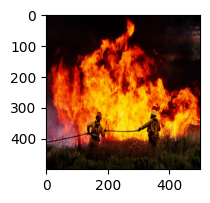

In [174]:
plt.figure(figsize=(2,2))
plt.imshow(img_test)
plt.show()

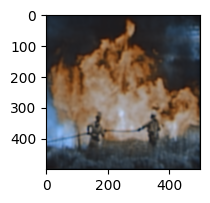

In [175]:
plt.figure(figsize=(2,2))
plt.imshow(output_np)
plt.show()

In [176]:
outputs = net.get_embedding(d)
outputs=outputs.detach().cpu().numpy()
out=(outputs - outputs.min())/(outputs.max()-outputs.min())
out=(out * 255).astype(np.uint8)
out=out.squeeze(0)
outshow=out.transpose(0,2,1)

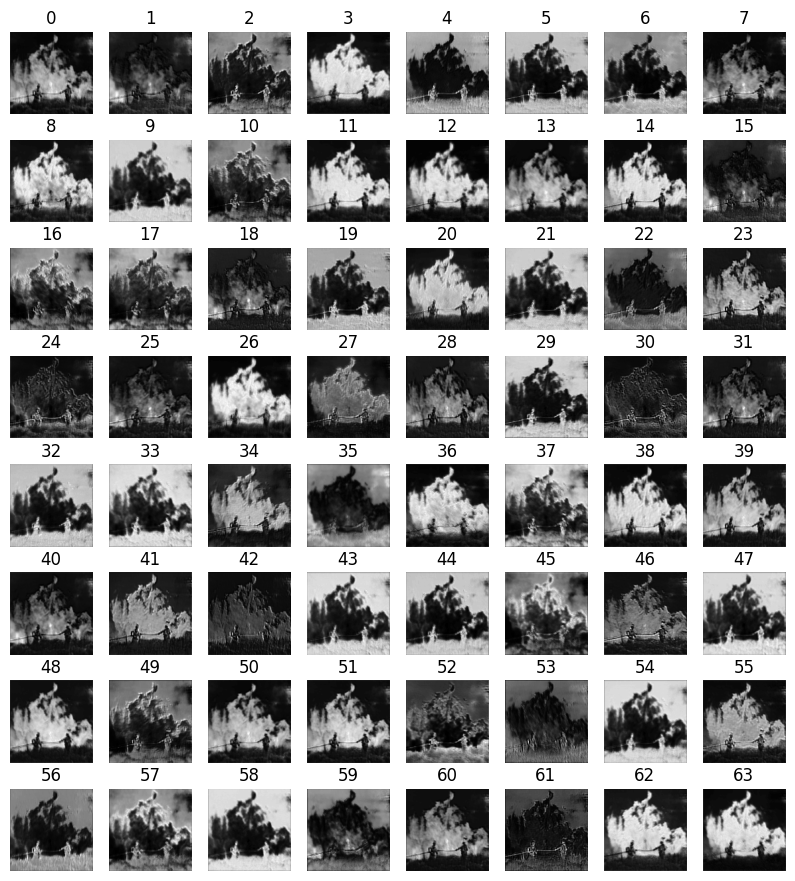

In [177]:
fig, ax = plt.subplots(8, 8,figsize=(10,11))
count=0
for i in range(8):
    for j in range(8):
        
        ax[i,j].imshow(outshow[count],cmap='grey')
        ax[i,j].axis('off')
        ax[i,j].title.set_text(count)
        count+=1
plt.show()

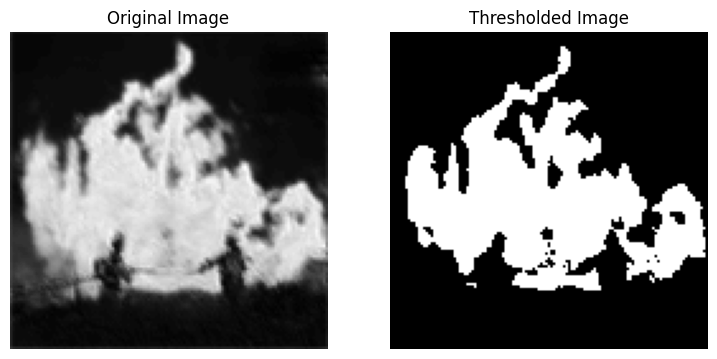

In [196]:
# Step 4: Apply Thresholding on a specific cluster (e.g., cluster 2)
#threshold_value = np.max(clustered_image)  # Example: Use max cluster as threshold
_, binary_image = cv2.threshold(outshow[63], 60, 255, cv2.THRESH_BINARY)

# Step 5: Display the Original, Clustered, and Thresholded Image
fig, ax = plt.subplots(1, 2, figsize=(9, 6))

ax[0].imshow(outshow[63], cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

#ax[1].imshow(clustered_image, cmap='viridis')
#ax[1].set_title('K-means Clustered Image')
#ax[1].axis('off')

ax[1].imshow(binary_image, cmap='gray')
ax[1].set_title('Thresholded Image')
ax[1].axis('off')
plt.show()


In [179]:
#out=out.transpose(1,2,0)
#out=out.reshape((125*125,64))

In [180]:
type(outshow)

numpy.ndarray

In [181]:
outshow[0].shape

(125, 125)

In [182]:
feature_arr = np.empty((0,) + outshow[0].shape)
features=[45]
count=0
for i in features:
    o=np.expand_dims(outshow[i], axis=0)
    feature_arr=np.append(feature_arr,o,axis=0)
    count+=1
feature_arr.shape

(1, 125, 125)

In [183]:
feature_array=feature_arr.transpose(1,2,0)
outsample=feature_array.reshape((125*125,count))

In [197]:
from sklearn.cluster import KMeans
n_clusters = 2

model = KMeans(n_clusters)
model.fit_predict(outsample)
labels = model.labels_  # Get the label of each pixel
kmeans_clustered_image = labels.reshape((125,125))
#clustered_image = model.reshape(125, 125)#.transpose(1,0)

In [198]:
'''# Step 4: Apply Thresholding on a specific cluster (e.g., cluster 2)
threshold_value = np.max(clustered_image)  # Example: Use max cluster as threshold
_, binary_image = cv2.threshold(feature_arr, 70, 255, cv2.THRESH_BINARY)

# Step 5: Display the Original, Clustered, and Thresholded Image
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(feature_arr[0], cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(clustered_image, cmap='viridis')
ax[1].set_title('K-means Clustered Image')
ax[1].axis('off')

ax[2].imshow(binary_image, cmap='gray')
ax[2].set_title('Thresholded Image')
ax[2].axis('off')

plt.show()
'''

"# Step 4: Apply Thresholding on a specific cluster (e.g., cluster 2)\nthreshold_value = np.max(clustered_image)  # Example: Use max cluster as threshold\n_, binary_image = cv2.threshold(feature_arr, 70, 255, cv2.THRESH_BINARY)\n\n# Step 5: Display the Original, Clustered, and Thresholded Image\nfig, ax = plt.subplots(1, 3, figsize=(18, 6))\n\nax[0].imshow(feature_arr[0], cmap='gray')\nax[0].set_title('Original Image')\nax[0].axis('off')\n\nax[1].imshow(clustered_image, cmap='viridis')\nax[1].set_title('K-means Clustered Image')\nax[1].axis('off')\n\nax[2].imshow(binary_image, cmap='gray')\nax[2].set_title('Thresholded Image')\nax[2].axis('off')\n\nplt.show()\n"

In [199]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
# Perform hierarchical clustering
Z = linkage(outsample, method='ward')  # Create linkage matrix
clusters = fcluster(Z, 2, criterion='maxclust')  

# Reshape clusters back to the original image shape
hc_clustered_image = clusters.reshape((125,125))  # (Height, Width)

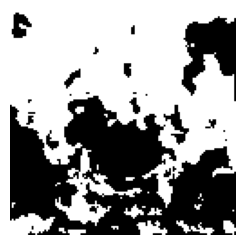

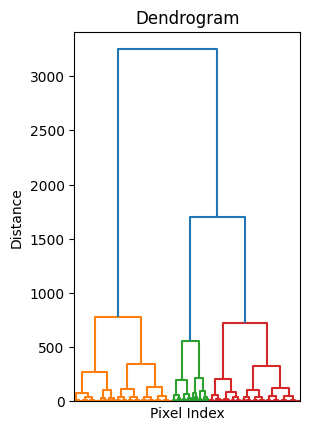

In [200]:
plt.subplot(1, 2, 1)
plt.imshow(hc_clustered_image, cmap='gray')
plt.axis('off')
plt.show()
plt.subplot(1, 2, 2)
dendrogram(Z, no_labels=True, color_threshold=0.5 * max(Z[:, 2]))
plt.title('Dendrogram')
plt.xlabel('Pixel Index')
plt.ylabel('Distance')
plt.show()

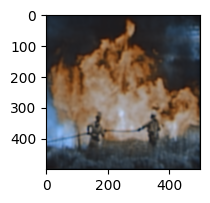

In [201]:
plt.figure(figsize=(2,2))
plt.imshow(output_np)
plt.show()

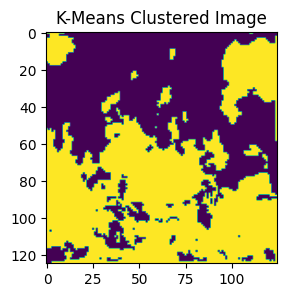

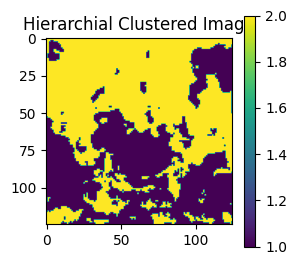

In [202]:
plt.figure(figsize=(3,3))
plt.imshow(kmeans_clustered_image)
plt.title('K-Means Clustered Image')
plt.show()
plt.figure(figsize=(3,3))
plt.imshow(hc_clustered_image)
plt.title('Hierarchial Clustered Image')
plt.colorbar()
plt.show()

In [162]:

cluster_0_image = np.where(hc_clustered_image == 2, 255, 0).astype(np.uint8) 

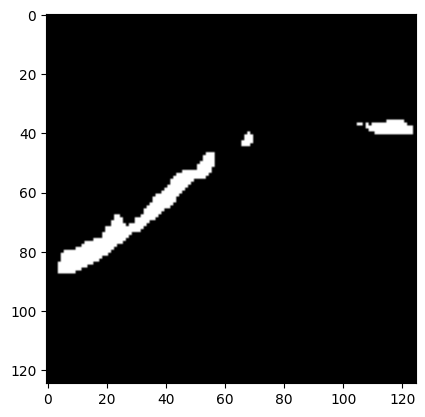

In [163]:
plt.imshow(cluster_0_image,cmap='gray')
plt.show()

In [101]:

cluster_0_image=torch.FloatTensor(cluster_0_image)
expanded_mask = np.repeat(cluster_0_image[:, :, np.newaxis], 64, axis=2)
expanded_mask=expanded_mask.unsqueeze(0)
expanded_mask.shape
expanded_mask=expanded_mask.permute(0,3,1,2)
expanded_mask=expanded_mask.to(device)
result=net.decoder(expanded_mask)

In [102]:
output13=result.squeeze(0)
output13=output13.detach().cpu().numpy()
final_result = (output13 - output13.min()) / (output13.max() - output13.min())
final_result=final_result.transpose(1,2,0)
final_result=(final_result * 255).astype(np.uint8)

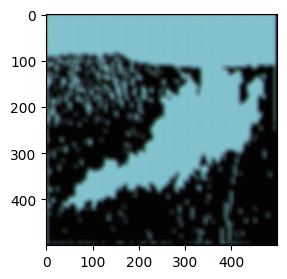

In [103]:
plt.figure(figsize=(3,3))
plt.imshow(final_result,cmap='viridis')
plt.show()

In [104]:
final_result[300][150]

array([3, 3, 3], dtype=uint8)

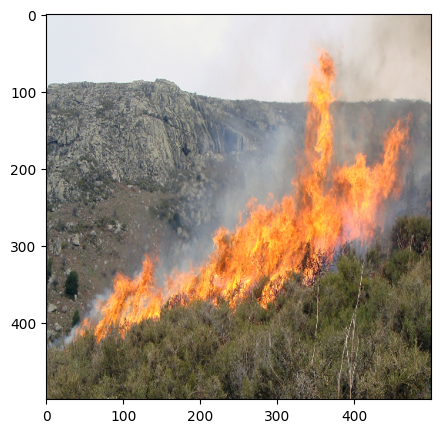

In [105]:

plt.figure(figsize=(5,5))
plt.imshow(img_test)
plt.show()

In [106]:
imd=img_test+final_result

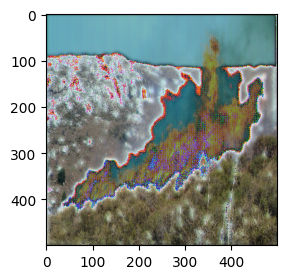

In [107]:
plt.figure(figsize=(3,3))
plt.imshow(imd)
plt.show()